<a href="https://colab.research.google.com/github/ZhiyuanH3/Candy-Analysis/blob/master/candy_analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import all the tools
import os
from matplotlib import pyplot as plt
import seaborn as sb

import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import norm, kstest

from hyperopt import fmin, Trials, tpe, hp, anneal

from sklearn.externals import joblib
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor as RFR

import statsmodels.api as sm

from keras import Sequential
from keras.layers import Dense 
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


In [0]:
!ls drive/My\ Drive/save/

abr_trials.joblib  rfr_trials.joblib


In [0]:
import urllib.request

# download csv data file
url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/candy-data.csv'
urllib.request.urlretrieve(url, './candy-data.csv')

('./candy-data.csv', <http.client.HTTPMessage at 0x7f783ac3eeb8>)

In [0]:
# read the csv file
inf = pd.read_csv('./candy-data.csv')
inf.head(4)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505


In [0]:
# drop the 'One dime' and 'One quarter' entries, since they are not really candies
inf.drop([2,3], axis=0, inplace=True)
inf.head(4)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
5,Almond Joy,1,0,0,1,0,0,0,1,0,0.465,0.767,50.347546


In [0]:
nRows, nCols = inf.shape
print('We have ', nRows, ' entries and ', nCols, ' variables.')

We have  83  entries and  13  variables.


In [0]:
# check if there're empty entries
inf.isna().sum()

competitorname      0
chocolate           0
fruity              0
caramel             0
peanutyalmondy      0
nougat              0
crispedricewafer    0
hard                0
bar                 0
pluribus            0
sugarpercent        0
pricepercent        0
winpercent          0
dtype: int64

In [0]:
inf[inf.winpercent>75].sort_values(by='winpercent', ascending=False)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
52,ReeseÕs Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.720,0.651,84.180290
51,ReeseÕs Miniatures,1,0,0,1,0,0,0,0,0,0.034,0.279,81.866257
79,Twix,1,0,1,0,0,1,0,1,0,0.546,0.906,81.642914
28,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,76.768600
64,Snickers,1,0,1,1,1,0,0,1,0,0.546,0.651,76.673782


In [0]:
inf[inf.winpercent<30].sort_values(by='winpercent', ascending=True)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
44,Nik L Nip,0,1,0,0,0,0,0,0,1,0.197,0.976,22.445341
7,Boston Baked Beans,0,0,0,1,0,0,0,0,1,0.313,0.511,23.417824
12,Chiclets,0,1,0,0,0,0,0,0,1,0.046,0.325,24.524988
72,Super Bubble,0,1,0,0,0,0,0,0,0,0.162,0.116,27.303865
26,Jawbusters,0,1,0,0,0,0,1,0,1,0.093,0.511,28.127439
57,Root Beer Barrels,0,0,0,0,0,0,1,0,1,0.732,0.069,29.703691


In [0]:
# function to generate ID that specifies the discrete features of a candy 
def gen_dupl_ID(row):
    id = ''
    for key in row:
        id += str(key)
    return id

df_with_ID = inf.copy()
df_with_ID['dupl_ID'] = inf.drop(['competitorname','sugarpercent','pricepercent','winpercent'], axis=1).apply(gen_dupl_ID, axis=1)

# check duplicated entries if continues variables not included
df_dupl = df_with_ID[['chocolate','dupl_ID']] 
print('Total number of duplicated entries: ', df_dupl.duplicated().sum())
df_dupl = df_dupl[df_dupl.duplicated(keep=False)]


dupl_group = df_dupl.groupby('dupl_ID')
for key, dfi in dupl_group:
    print('dupl_ID: ', key)
    print('number of duplicates: ', len(dfi))

# 19 entries have the same categorical config --> is this a problem? 

Total number of duplicated entries:  55
dupl_ID:  000000001
number of duplicates:  3
dupl_ID:  010000000
number of duplicates:  5
dupl_ID:  010000001
number of duplicates:  19
dupl_ID:  010000100
number of duplicates:  5
dupl_ID:  010000101
number of duplicates:  7
dupl_ID:  100000001
number of duplicates:  6
dupl_ID:  100000010
number of duplicates:  4
dupl_ID:  100001010
number of duplicates:  3
dupl_ID:  100010010
number of duplicates:  2
dupl_ID:  100100000
number of duplicates:  3
dupl_ID:  100100001
number of duplicates:  3
dupl_ID:  100100010
number of duplicates:  3
dupl_ID:  101000001
number of duplicates:  2
dupl_ID:  101001010
number of duplicates:  2
dupl_ID:  101010010
number of duplicates:  2
dupl_ID:  101110010
number of duplicates:  2


In [0]:
# store the IDs of the candys that have high discrete feature duplication
n_dupls = [19,7,6]
key_dupl = {}
for key, dfi in dupl_group:
    n_dupl = len(dfi)
    for i in n_dupls:
        if n_dupl == i:
            key_dupl[i] = key

In [0]:
cols = list(inf.columns)

# discrete feature names: discard candy names and continues variables here 
ingredients = cols[1:-3]
ingredients

['chocolate',
 'fruity',
 'caramel',
 'peanutyalmondy',
 'nougat',
 'crispedricewafer',
 'hard',
 'bar',
 'pluribus']

num of duplicated entries:  19


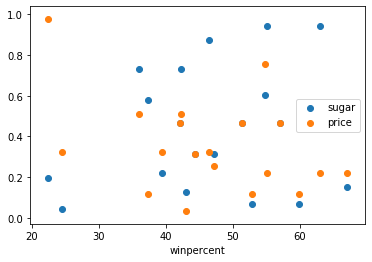

num of duplicated entries:  7


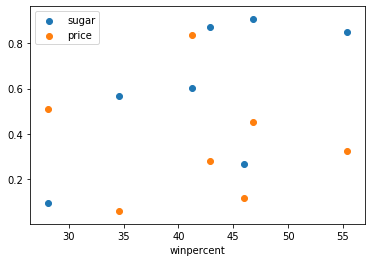

num of duplicated entries:  6


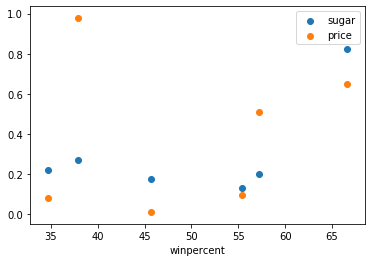

In [0]:
# relationships between contintuous variables and 'winpercent' for candies with identical discrete feature configuration
same_ID = {}
df_tmp = df_with_ID.drop(ingredients+['competitorname','dupl_ID'], axis=1)
for i in n_dupls:
    same_ID[i] = df_tmp[df_with_ID.dupl_ID == key_dupl[i]]

for i in n_dupls:
    print('num of duplicated entries: ', i)
    plt.scatter(same_ID[i].winpercent, same_ID[i].sugarpercent, label='sugar')
    plt.scatter(same_ID[i].winpercent, same_ID[i].pricepercent, label='price')
    plt.xlabel('winpercent')
    plt.legend()
    plt.show()
    plt.close()

In [0]:
# the corresponding correlation matrices
for i in n_dupls:
    print('num of duplicated entries: ', i)
    print(same_ID[i].corr())

# no consistent correlation found

num of duplicated entries:  19
              sugarpercent  pricepercent  winpercent
sugarpercent      1.000000      0.145797    0.195447
pricepercent      0.145797      1.000000   -0.388035
winpercent        0.195447     -0.388035    1.000000
num of duplicated entries:  7
              sugarpercent  pricepercent  winpercent
sugarpercent      1.000000      0.028153    0.655700
pricepercent      0.028153      1.000000   -0.091717
winpercent        0.655700     -0.091717    1.000000
num of duplicated entries:  6
              sugarpercent  pricepercent  winpercent
sugarpercent      1.000000      0.452989    0.574848
pricepercent      0.452989      1.000000    0.119001
winpercent        0.574848      0.119001    1.000000


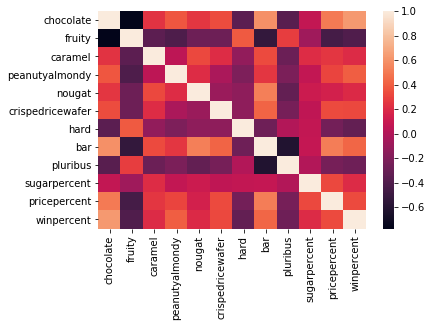

In [0]:
# check the dependencies of the variables 
sb.heatmap(inf.corr())
#inf.corr()

In [0]:
# zoom in to check the dependency 
# 'chocolate' and 'winpercent' are correlated
inf[['chocolate','winpercent']].corr()

,chocolate,winpercent
chocolate,1.000000,0.632373
winpercent,0.632373,1.000000


In [0]:
# zoom in to check the dependency 
# 'chocolate' and 'fruity' have high negative correlation
inf[['chocolate','fruity']].corr()

,chocolate,fruity
chocolate,1.0000,-0.7755
fruity,-0.7755,1.0000


In [0]:
print('number of candies that contain chocolate and are fruity: ', inf[(inf.chocolate==1) & (inf.fruity==1)].shape[0])
# variable 'chocolate' and 'fruity' are mutually exclusive

number of candies that contain chocolate and are fruity:  1


In [0]:
# zoom in to check the dependency 
# 'chocolate' and 'bar' have some correlation
inf[['chocolate','hard','bar']].corr()

,chocolate,hard,bar
chocolate,1.000000,-0.358230,0.593165
hard,-0.358230,1.000000,-0.273341
bar,0.593165,-0.273341,1.000000


In [0]:
print('number of candies that contain chocolate and are hard: ', inf[(inf.chocolate==1) & (inf.hard==1)].shape[0])
# variable 'chocolate' and 'hard' are mutually excluded

number of candies that contain chocolate and are hard:  1


In [0]:
#df_choco = inf[inf.chocolate==1]
#df_choco.drop(['chocolate','fruity','hard'], axis=1, inplace=True)

In [0]:
# zoom in to check the dependency 
# 'bar' and 'pluribus' have some negative correlation
inf[['bar','pluribus']].corr()

,bar,pluribus
bar,1.00000,-0.61817
pluribus,-0.61817,1.00000


,sugarpercent,pricepercent,winpercent
sugarpercent,1.000000,0.321587,0.207635
pricepercent,0.321587,1.000000,0.333861
winpercent,0.207635,0.333861,1.000000


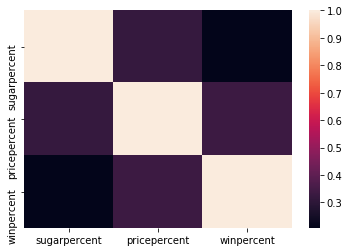

In [0]:
# zoom in to check the dependency 
sugar_price_win_corr = inf[['sugarpercent','pricepercent','winpercent']].corr()
sb.heatmap(sugar_price_win_corr)
sugar_price_win_corr

Text(0, 0.5, 'winpercent')

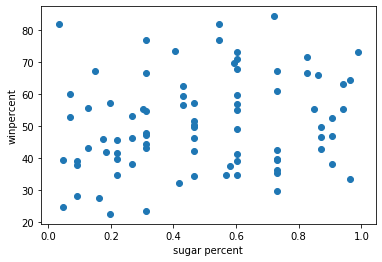

In [0]:
plt.scatter(inf.sugarpercent, inf.winpercent)
plt.xlabel('sugar percent')
plt.ylabel('winpercent')

# some candies share the same sugar content

Text(0, 0.5, 'winpercent')

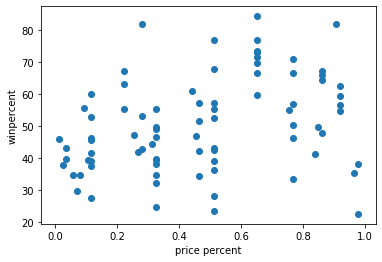

In [0]:
plt.scatter(inf.pricepercent, inf.winpercent)
plt.xlabel('price percent')
plt.ylabel('winpercent')

# some candies share the same price

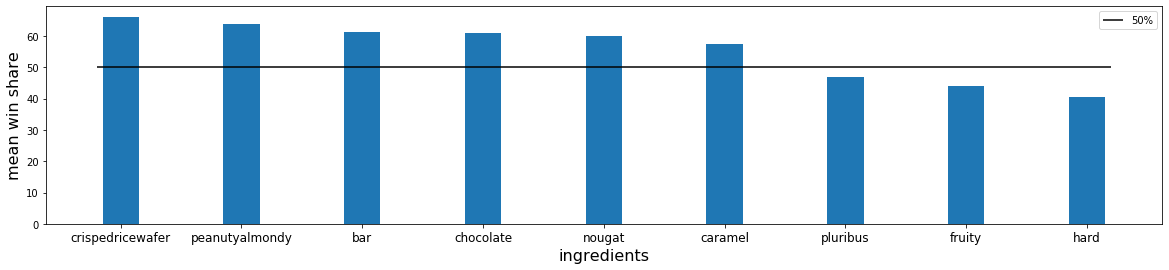

In [0]:
# check the average winpercent of the candies, wich have a certain feature
mean_win_share = []
for key in ingredients:
    mean_win_share.append(inf[inf[key] == 1].winpercent.mean())

df_mean_win_share = pd.DataFrame({'ingredient': ingredients, 'mean_win_share': mean_win_share})
df_mean_win_share = df_mean_win_share.sort_values('mean_win_share', ascending=False)


plt.bar(df_mean_win_share.ingredient, df_mean_win_share.mean_win_share, width=0.3)
plt.hlines(y=50, xmin=-0.2, xmax=8.2, label='50%')
plt.xlabel('ingredients',fontsize=16)
plt.ylabel('mean win share',fontsize=16)
plt.xticks(fontsize=12)
plt.legend()

fig = plt.gcf()
fig.set_size_inches(20,4)
plt.show()

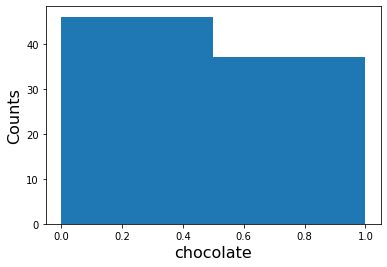

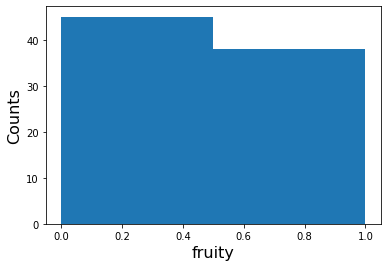

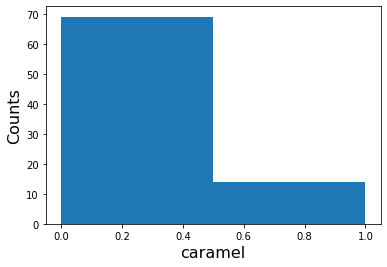

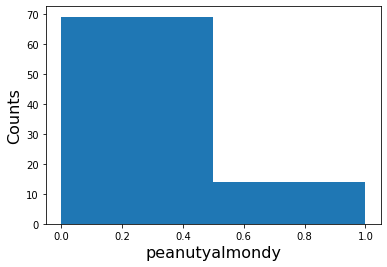

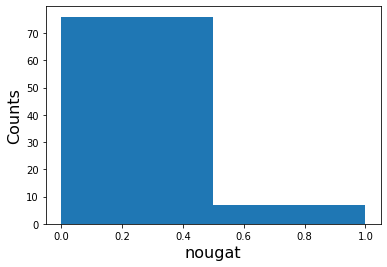

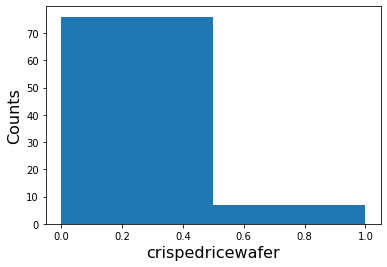

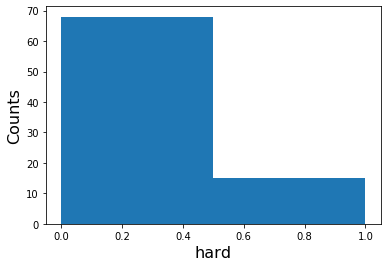

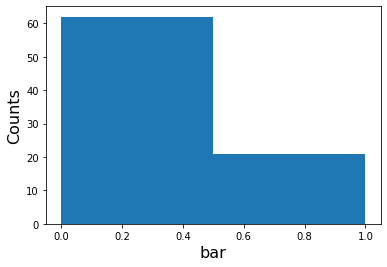

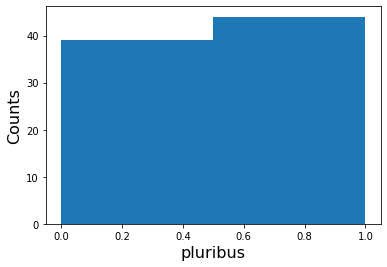

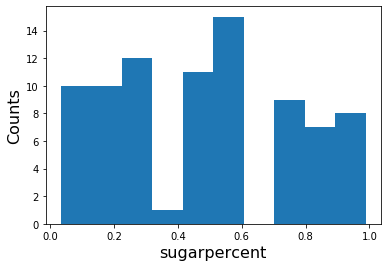

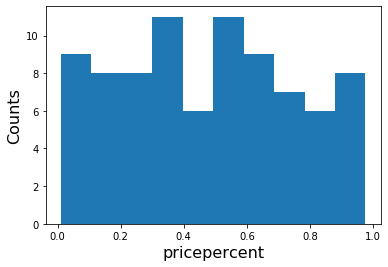

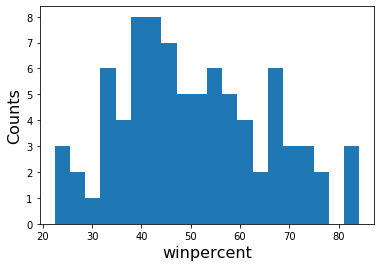

In [0]:
# plot the feature distributions
for key in inf.columns:
    if key in ['competitorname']:
        continue
    if key in ['sugarpercent', 'pricepercent']:
        Bins = 10
    elif key == 'winpercent':
        Bins = 20    
    else:
        Bins = 2
    plt.hist(inf[key], bins=Bins)
    plt.xlabel(key, fontsize=16)
    plt.ylabel('Counts',fontsize=16)
    plt.show()
    plt.close()

# one needs to be more careful about a feature with unbalanced distribution 

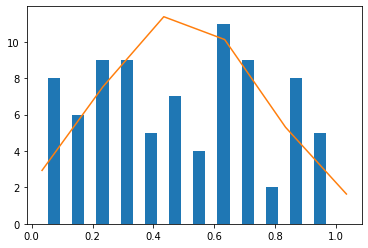

p-value for KS-test(normal distribution) of 'sugarpercent':  0.1333627469338972


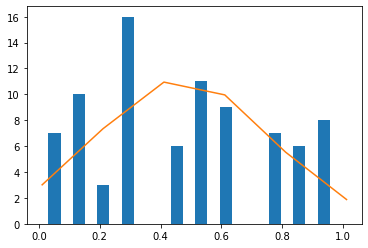

p-value for KS-test(normal distribution) of 'pricepercent':  0.10276847593359534


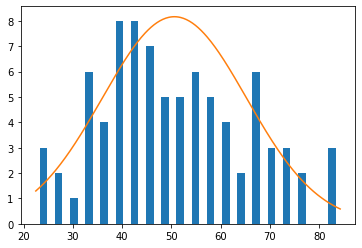

p-value for KS-test(normal distribution) of 'winpercent':  0.6387823087164539


In [0]:
# KS-test: 
# null hypothesis: the compared two distributions are identical

for i in ['sugar', 'price', 'win']:

    data_i = inf[i+'percent']

    if i == 'win':
        offset = 300
        Bins = 20
    else:
        offset = 8
        Bins = 12 #np.arange(data_i.min(), data_i.max()+0.2, 0.2)
    
    loc_i, scale_i = norm.fit(data_i)
    n_i = norm(loc=loc_i, scale=scale_i)

    plt.hist(data_i, bins=Bins, rwidth=0.5)
    x_i = np.arange(data_i.min(), data_i.max()+0.2, 0.2)
    y_i = offset * n_i.pdf(x_i)
    plt.plot(x_i, y_i)
    plt.show()

    print("p-value for KS-test(normal distribution) of '" + i + "percent': ", kstest(data_i, n_i.cdf).pvalue)

# the hypothesis that 'sugarpercent' is normal distributed can not be rejected according to the KS-test
# the hypothesis that 'pricepercent' is normal distributed can not be rejected according to the KS-test
# the hypothesis that 'winpercent' is normal distributed can not be rejected according to the KS-test

In [0]:
# check multicolinearities

T_critical = 0.1

for pair in [['chocolate','fruity'], ['bar','pluribus'], ['chocolate','hard']]:
    print(pair[0], 'vs. ', pair[1])
    X = sm.add_constant(inf[pair[0]])
    Y = inf[pair[1]]
    ols_model = sm.OLS(Y, X)
    ols_result = ols_model.fit()
    T_pair = 1 - np.round(ols_result.rsquared, decimals=3)
    critical = T_pair < T_critical
    print('Tolerance T: ', T_pair, ' < ' if critical else ' > ', T_critical, ', indicating', '' if critical else ' tolerable', " multicolinearity between '", pair[0],"' and '", pair[1],"'")



chocolate vs.  fruity
Tolerance T:  0.399  >  0.1 , indicating  tolerable  multicolinearity between ' chocolate ' and ' fruity '
bar vs.  pluribus
Tolerance T:  0.618  >  0.1 , indicating  tolerable  multicolinearity between ' bar ' and ' pluribus '
chocolate vs.  hard
Tolerance T:  0.872  >  0.1 , indicating  tolerable  multicolinearity between ' chocolate ' and ' hard '


In [0]:
print("p-value for KS-test(normal distribution) of 'winpercent':")
for key in ingredients:
    for j in [0,1]:
        data_i = inf[inf[key]==j].winpercent
        
        loc_i, scale_i = norm.fit(data_i)
        n_i = norm(loc=loc_i, scale=scale_i)
        print(key, " = "+str(j)+": ", kstest(data_i, n_i.cdf).pvalue)

p-value for KS-test(normal distribution) of 'winpercent':
chocolate  = 0:  0.9492148247405449
chocolate  = 1:  0.9710361135906722
fruity  = 0:  0.8820711287186673
fruity  = 1:  0.9920659537814703
caramel  = 0:  0.7964820383704407
caramel  = 1:  0.8845437853200384
peanutyalmondy  = 0:  0.53264181458472
peanutyalmondy  = 1:  0.481788824853246
nougat  = 0:  0.6502447525555118
nougat  = 1:  0.9972661626655505
crispedricewafer  = 0:  0.6070005976392068
crispedricewafer  = 1:  0.9744311620240984
hard  = 0:  0.9848385969621437
hard  = 1:  0.9014602129763439
bar  = 0:  0.4274752497279446
bar  = 1:  0.9991128292721562
pluribus  = 0:  0.9163626707444353
pluribus  = 1:  0.9394248652280194


In [0]:
# all the p-values are larger than 0.05, which means
# the hypothesis that 'winpercent' is normal distributed for each of the above cases can not be rejected according to the KS-test

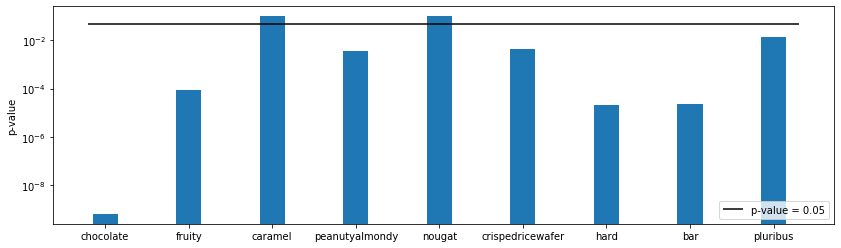

In [0]:
p_vals = []

for key in ingredients:
    tA = inf[inf[key] == 0].winpercent
    tB = inf[inf[key] == 1].winpercent
    p_vals.append(sp.stats.ttest_ind(tA, tB, equal_var=False).pvalue)

plt.bar(x=ingredients, height=p_vals, width=0.3)
plt.hlines(y=0.05, xmin=-0.2, xmax=len(ingredients)-0.7, label='p-value = 0.05')
plt.yscale('log')
plt.ylabel('p-value')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(14,4)
plt.show()

# variable 'caramel' and 'nougat' can be discarded in a linear model, since whether a candy has these features has limited effect on the 'winpercent'

In [0]:
X_linear = inf.drop(['competitorname','winpercent']+['caramel','nougat'], axis=1) #['sugarpercent','pricepercent']
y_linear = inf.winpercent

In [0]:
# linear model
X = sm.add_constant(X_linear)
Y = y_linear
ols_model = sm.OLS(Y, X)
ols_result = ols_model.fit()
print(ols_result.summary())

# the dependencies from variable 'crispedricewafer', 'hard', 'bar', 'pluribus' and 'pricepercent' are not significant

                            OLS Regression Results                            
Dep. Variable:             winpercent   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     9.576
Date:                Mon, 17 Feb 2020   Prob (F-statistic):           1.73e-09
Time:                        00:59:26   Log-Likelihood:                -308.28
No. Observations:                  83   AIC:                             636.6
Df Residuals:                      73   BIC:                             660.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               32.9395      4.869  

Text(0.5, 0, 'predicted winpercent')

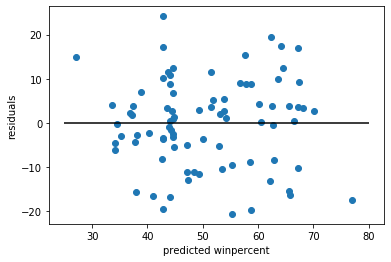

In [0]:
# residuals scatter plot
resid = ols_result.resid
pred_winpercent = ols_result.fittedvalues
pred_winpercent
plt.scatter(pred_winpercent, resid)
plt.hlines(y=0, xmin=25, xmax=80)
plt.ylabel('residuals')
plt.xlabel('predicted winpercent')

In [0]:
# what features should our new candy has?
# suggestions from the linear model:
# chocolate: yes
# fruity: yes
# peanutyalmondy: yes
# sugar content: should be just higher than the sugar content of all the 83 candies 
# others: one can follow what the coefficients from the linear model suggest (as long as the expense allows)
# , but they have limited effects 


# note that no candies with feature 'chocolate' has feaure 'fruity' (with only one exception) 
# and the average 'winpercent' for 'fruity' candies is below 50%
# so 'fruity' is not suggested if 'chocolate' is presented

# final suggestions:
# since price seems not to affect winpercent too much, we can allow features, which have little positive effect on winpercent 
# chocolate: yes
# fruity: no
# caramel: yes (since candies with caramel have above 50% mean win share, but has limited effect)
# peanutyalmondy: yes
# nougat: yes (since candies with nougat have above 50% mean win share, but has limited effect)
# crispedricewafer: yes
# hard: no (since chocolate and hard are mutually exclusive)
# bar: yes
# pluribus: no
# sugar content: should be just higher than the sugar content of all the 83 candies 

In [0]:
# can the regression be improved by non-linear models?
# (not by much)

In [0]:
# this dataframe contains less features 
X_linear1 = X_linear.drop(['crispedricewafer','hard','bar','pluribus','pricepercent'], axis=1)

In [0]:
"""
# linear model
X1 = sm.add_constant(X_linear1)
Y = y_linear
ols_model1 = sm.OLS(Y, X1)
ols_result1 = ols_model1.fit()
print(ols_result1.summary())
"""

"""
linear_model = LR()
linear_model.fit(X_linear1, y_linear)

R_2 = linear_model.score(X_linear1, y_linear)
print('R squared of the fit: ', R_2)


df_coef = pd.DataFrame({'features': X_linear1.columns, 'coef': linear_model.coef_})
print(df_coef.sort_values('coef', ascending=False))


# best candy configuration according to the model:
hyp_candy_1 = (linear_model.coef_ > 0).astype(int)
print('predicted winpercent: ', round(list(linear_model.predict([hyp_candy_1]))[0]))
"""

"\nlinear_model = LR()\nlinear_model.fit(X_linear1, y_linear)\n\nR_2 = linear_model.score(X_linear1, y_linear)\nprint('R squared of the fit: ', R_2)\n\n\ndf_coef = pd.DataFrame({'features': X_linear1.columns, 'coef': linear_model.coef_})\nprint(df_coef.sort_values('coef', ascending=False))\n\n\n# best candy configuration according to the model:\nhyp_candy_1 = (linear_model.coef_ > 0).astype(int)\nprint('predicted winpercent: ', round(list(linear_model.predict([hyp_candy_1]))[0]))\n"

In [0]:
seed = 0
n_folds = 10

In [0]:
# turn DataFrames into numpy arrays
X_l = X_nl = np.array(X_linear)
X_l1 = X_nl1 = np.array(X_linear1)

y_l = y_nl = np.array(y_linear)

In [0]:
# compute cross validation score
def run_CV_0(model, data, labels, model_name, params):
    cv_scores = []
    k_folds = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    n_feats = data.shape[1]

    for i_trn, i_tst in k_folds.split(labels):
        i_model = model(params)
        #i_model.fit(data[i_trn], labels[i_trn])
        #i_model.compile(optimizer='adam', loss='MSE')
        i_score = fit_eval_skl(i_model, data[i_trn], labels[i_trn], data[i_tst], labels[i_tst])
        cv_scores.append(i_score) 

    mn_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    print(n_folds, 'fold cross validation score for model "', model_name, '": %.2f +- %.2f' % (mn_score, std_score))
    return mn_score #cv_scores


# varies models
# linear regression
def model_lr(params): # 10 fold cv mse = 127.69 +- 39.35
    model =  LR()
    return model

# ridge regression
def model_ridge(params):
    model = Ridge(alpha=2)
    return model

#lasso regression
def model_lasso(params):
    model = Lasso(alpha=0.2)
    return model

# random forest regression
def model_rfr(params): 
    model = RFR(
        criterion='mse',
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']), 
        min_samples_leaf=int(params['min_samples_leaf']),
        min_samples_split=int(params['min_samples_split']),
        n_jobs=-1,
        verbose=0,
        random_state=seed)
    return model


# fit and evaluate model    
def fit_eval_skl(model, X_trn, y_trn, X_tst, y_tst):    
    model.fit(X_trn, y_trn)
    y_pred = model.predict(X_tst)
    return mse(y_tst, y_pred)

#print(model.feature_importances_)

In [0]:
# taking 4 input variables
cv_scores_lr = run_CV_0(model_lr, X_l1, y_l, 'linear', {})
cv_scores_ridge = run_CV_0(model_ridge, X_l1, y_l, 'ridge', {})
cv_scores_lasso = run_CV_0(model_lasso, X_l1, y_l, 'lasso', {})
cv_scores_rfr = run_CV_0(model_rfr, X_nl1, y_nl, 'random forest', {'max_depth': 2.0, 'min_samples_leaf': 4.0, 'min_samples_split': 16.0, 'n_estimators': 800.0})

10 fold cross validation score for model " linear ": 127.69 +- 39.35
10 fold cross validation score for model " ridge ": 127.66 +- 40.49
10 fold cross validation score for model " lasso ": 129.56 +- 39.96
10 fold cross validation score for model " random forest ": 124.68 +- 41.80


In [0]:
# taking 9 input variables
cv_scores_lr_9 = run_CV_0(model_lr, X_l, y_l, 'linear', {})
cv_scores_ridge_9 = run_CV_0(model_ridge, X_l, y_l, 'ridge', {})
cv_scores_lasso_9 = run_CV_0(model_lasso, X_l, y_l, 'lasso', {})
cv_scores_rfr_9 = run_CV_0(model_rfr, X_l, y_l, 'random forest', {'max_depth': 2.0, 'min_samples_leaf': 4.0, 'min_samples_split': 16.0, 'n_estimators': 800.0})

10 fold cross validation score for model " linear ": 141.03 +- 56.75
10 fold cross validation score for model " ridge ": 131.92 +- 44.55
10 fold cross validation score for model " lasso ": 132.99 +- 47.35
10 fold cross validation score for model " random forest ": 130.59 +- 47.35


In [0]:
# (non-linearity has limited effect on improvement of the regression)

In [0]:
# functions to compute target scores for hyperopt

def rfr_score(params):
    #cv_scores_rfr = run_CV_0(model_rfr, X_nl1, y_nl, 'random forest', params)
    cv_scores_rfr = run_CV_0(model_rfr, X_l, y_l, 'random forest', params)
    return cv_scores_rfr



def abr_score(params):
    #cv_scores_abr = run_CV_0(model_rfr, X_nl1, y_nl, 'random forest', params)
    cv_scores = run_CV_0(model_abr, X_l, y_l, 'AdaBoosting', params)
    return cv_scores

In [0]:
# hyperparameter search spaces
spaces = {}

spaces['rfr'] = {
    'n_estimators': hp.quniform('n_estimators', 50, 800, 100),
    'max_depth' : hp.quniform('max_depth', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1), 
    'min_samples_split': hp.quniform('min_samples_split', 6, 22, 2),
}


# files to save tuning progress
model_list = ['rfr']
trials_dic = {}
for key in model_list:
    name_i = key+'_trials.joblib'
    if os.path.exists(name_i):
        trials = joblib.load(name_i)
    else:
        trials = Trials()

#if os.path.exists('trials1.joblib'):
#    trials = joblib.load('trials1.joblib')
#else:
#    trials = Trials()

In [0]:
"""
n_periods = 24#2
save_period = 5
n_iter_this = n_periods * save_period
print('current number of trials: ', len(trials))

for i in range(int(n_iter_this/save_period)):

    n_iter_i = save_period + len(trials)

    Best = fmin(
                 fn = rfr_score,
                 space = space,
                 algo = tpe.suggest,
                 max_evals = n_iter_i,
                 trials = trials,
                 rstate = np.random.RandomState(seed),
                 verbose = True
               )
    
    if True:
        print('saving..')
        joblib.dump(trials, 'trials1.joblib')
        !cp trials.joblib drive/My\ Drive/save/trials.joblib
"""

current number of trials:  374
10
fold cross validation score for model "
random forest
": 125.88 +- 46.73
10
fold cross validation score for model "
random forest
": 128.72 +- 45.34
10
fold cross validation score for model "
random forest
": 126.55 +- 45.62
10
fold cross validation score for model "
random forest
": 132.56 +- 49.15
10
fold cross validation score for model "
random forest
": 127.88 +- 46.57
100%|██████████| 5/5 [01:15<00:00, 14.72s/it, best loss: 125.18902460170848]
saving..
10
fold cross validation score for model "
random forest
": 125.22 +- 45.38
10
fold cross validation score for model "
random forest
": 125.60 +- 46.66
10
fold cross validation score for model "
random forest
": 126.77 +- 43.95
10
fold cross validation score for model "
random forest
": 125.47 +- 46.44
10
fold cross validation score for model "
random forest
": 130.91 +- 46.80
100%|██████████| 5/5 [01:09<00:00, 13.38s/it, best loss: 125.18902460170848]
saving..
10
fold cross validation score for mo

In [0]:
print('best parameters: ', Best)
#trials.results

best parameters:  {'max_depth': 2.0, 'min_samples_leaf': 4.0, 'min_samples_split': 16.0, 'n_estimators': 800.0}


In [0]:
"""
rfr4 = model_rfr()
rfr4.fit(X_nl1, y_nl)
print('total mean square error for random forest model: ', mse(y_nl, rfr4.predict(X_nl1)))
print(rfr4.predict([[1,1,1,1]])[0])
print(rfr4.predict([[1,0,1,1]])[0])
print(rfr4.predict([[0,1,0,0.16]])[0])

lr4 = model_lr()
lr4.fit(X_nl1, y_nl)
print('total mean square error for linear model: ', mse(y_nl, lr4.predict(X_nl1)))
print(lr4.predict([[1,1,1,1]])[0])
print(lr4.predict([[1,0,1,1]])[0])
print(lr4.predict([[0,1,0,0.16]])[0])
"""

In [0]:
"""
df_test = pd.DataFrame({'y_pred': rfr4.predict(X_nl1), 'y_true': y_nl})
df_test['res'] = np.square(df_test.y_true - df_test.y_pred)
df_test.res.sum()/len(df_test)

df_t = pd.DataFrame({'y_pred': lr4.predict(X_nl1), 'y_true': y_nl})
df_t['res'] = np.square(df_t.y_true - df_t.y_pred)
df_t.res.sum()/len(df_t)

pd.set_option('display.max_rows', 90)
df_tt = pd.merge( df_test.drop('res', axis=1), df_t.drop('res', axis=1), on='y_true', suffixes=('_rfr','_lr') ).sort_values('y_true', ascending=False)
df_tt
"""


"""
rfr9 = model_rfr()
rfr9.fit(X_l, y_l)
print(rfr9.predict([[1,1,1,1,0,1,0,1,0]])[0])
print(rfr9.predict([[1,0,0,1,0,0,0,0.72,0.65]])[0])

lr9 = model_lr()
lr9.fit(X_l, y_l)
print(lr9.predict([[1,1,1,1,0,1,0,1,0]])[0])
print(lr9.predict([[1,0,0,1,0,0,0,0.72,0.65]])[0])
"""

In [0]:
# does neural network help?
# (not really and it took way longer to convert)

In [0]:
n_epochs = 4000

ES = EarlyStopping(monitor='val_loss',
                   patience=5,
                   restore_best_weights=True)    

# number of model params: in_dim + 1
def model_linear(in_dim):
    model = Sequential()
    model.add(Dense(1, input_dim=in_dim))
    #model.compile(optimizer='adam', loss='MSE')
    #print(model.summary())
    return model

# number of model params: in_dim + 1
def model_nl1(in_dim):
    model = Sequential()
    model.add(Dense(1, input_dim=in_dim, activation='sigmoid'))
    return model

# number of model params: (in_dim+1) * n_nodes + (n_nodes+1) * 1
def model_nl2(in_dim):
    n_nodes = 2
    model = Sequential()
    model.add(Dense(n_nodes, input_dim=in_dim, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# fit and evaluate model
def fit_eval(model, X_trn, y_trn, X_tst, y_tst, n_epochs):
    model.fit(
        x=X_trn,
        y=y_trn/100,
        batch_size=83, #32,
        epochs=n_epochs,
        shuffle=True,
        validation_split=0.2,
        callbacks=[ES],
        verbose=0
        )
    return mse(y_tst, 100 * model.predict(X_tst))

# compute cross validation scores
def run_CV(model, data, labels, model_name):
    cv_scores = []
    k_folds = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    n_feats = data.shape[1]

    for i_trn, i_tst in k_folds.split(labels):
        i_model = model(n_feats)
        i_model.compile(optimizer='adam', loss='MSE')
        i_score = fit_eval(i_model, data[i_trn], labels[i_trn], data[i_tst], labels[i_tst], n_epochs)
        cv_scores.append(i_score) 

    #print(i_model.summary())

    print(n_folds, 'fold cross validation score for model "', model_name, '": %.2f +- %.2f' % (np.mean(cv_scores), np.std(cv_scores)))
    return cv_scores

In [0]:
cv_scores_l = run_CV(model_linear, X_l1, y_l, 'linear')
#cv_scores_nl1 = run_CV(model_nl1, X_l1, y_l, 'non-linear1')
cv_scores_nl2 = run_CV(model_nl2, X_nl1, y_nl, 'non-linear2')

10 fold cross validation score for model " linear ": 165.55 +- 83.99
10 fold cross validation score for model " non-linear2 ": 161.74 +- 64.73


In [0]:
"""
nn_linear = model_linear(in_dim=9)
nn_linear.compile(optimizer='adam', loss='MSE')
print(nn_linear.summary())

if_trn = True
if if_trn:
    nn_linear.fit(
            x=X_linear,
            y=y_linear/100,
            batch_size=32,
            epochs=n_epochs,
            shuffle=True,
            #validation_split=0.2,
            callbacks=[ES],
            verbose=0 
            )
    
pd.DataFrame({'features': X_linear.columns, 'weights': nn_linear.layers[0].get_weights()[0].reshape((1,-1))[0]})    


w = nn_linear.layers[0].get_weights()[0]
#ww = np.array(w)
www = np.array([i[0] for i in w])   

best = (www > 0).reshape((-1,9))#.astype(int)
df_best = pd.DataFrame({'features': X_linear.columns[:-2], 'presented': best[0][:-2]}) 
print('best config: ')
print(df_best)
print('predicted winpercent: ', round(nn_linear.predict(best)[0,0] * 100, 1))
"""

In [0]:
"""
# trying out some generated features

df_new_var = pd.DataFrame()
df_new_var['winpercent'] = inf.winpercent 

df_new_var['sugar_above_avg'] = (inf.sugarpercent > 0.5).astype(int)
df_new_var['price_above_avg'] = (inf.pricepercent > 0.5).astype(int)
df_new_var['sugar_price_ratio'] = inf.sugarpercent / inf.pricepercent


df_new_var['n_features1'] = inf.fruity + inf.peanutyalmondy + inf.nougat + inf.crispedricewafer 
df_new_var['n_features2'] = inf.fruity + inf.caramel + inf.nougat + inf.crispedricewafer 
df_new_var['n_features3'] = inf.fruity + inf.caramel + inf.peanutyalmondy + inf.crispedricewafer 
df_new_var['n_features4'] = inf.fruity + inf.caramel + inf.peanutyalmondy + inf.nougat 
df_new_var['n_features5'] = inf.fruity + inf.caramel + inf.peanutyalmondy + inf.nougat + inf.crispedricewafer 
df_new_var['n_features6'] = inf.caramel + inf.peanutyalmondy + inf.nougat + inf.crispedricewafer 
df_new_var['n_features7'] = inf.peanutyalmondy + inf.nougat + inf.crispedricewafer
df_new_var['n_features8'] = inf.peanutyalmondy + inf.crispedricewafer
df_new_var['n_features9'] = inf.peanutyalmondy + inf.nougat


new_vars = ['sugar_above_avg',
            'price_above_avg',
            'sugar_price_ratio',
            'n_features1',
            'n_features2',
            'n_features3',
            'n_features4',
            'n_features5',
            'n_features6',
            'n_features7',  
            'n_features8',   
            'n_features9',
            ]

new_var_win_corr = df_new_var.corr()
sb.heatmap(new_var_win_corr)
new_var_win_corr
"""

In [0]:
# no significant improvement from non-linear model over linear model found
#

## todos

1. Is the matches truely random?
2. Is the choices of the participants random? Do they represent the whole population?
3. What other features of the candies can be explored?
4. New features?

In [0]:
    # 600 5 6 -> 127.05 +- 42.08
    # 500 6 6 -> 127.05 +- 42.06
    # 500 6 5 -> 126.94 +- 43.35
    # 600 6 5 -> 126.82 +- 43.26
    # 600 7 5 -> 126.82 +- 43.26

    # 600 3 5 -> 126.09 +- 42.54
    # 650 3 5 -> 126.04 +- 42.53
    # 650 3 5 15 -> 124.83 +- 41.15
    # 650 3 5 17 -> 124.77 +- 40.28
    # 650 2 5 17 -> 123.37 +- 40.64
    # 650 2 5 14 -> 123.16 +- 40.83
    
    """
    model = RFR(
        criterion='mse',
        n_estimators=650,
        max_depth=2, 
        min_samples_leaf=5,
        min_samples_split=14,
        n_jobs=-1,
        verbose=0,
        random_state=seed)
    """